In [1]:
import numpy as np
from osgeo import gdal
from skimage.morphology import disk
from skimage.filters import median
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, Point
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap,Normalize,to_rgba
%matplotlib inline
plt.rcParams['font.sans-serif'] = 'Arial' # Choose a nice font here
plt.rcParams['font.size'] = 7 # standard font size
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial'
plt.rcParams['figure.facecolor'] = 'white' # make sure background isn't transparent
plt.rcParams['figure.dpi'] = 150

ModuleNotFoundError: No module named 'osgeo'

# Constants and definitions

In [2]:
def using_clump(a,b):
    return [a[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))],[b[s] for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

def DoRotation(xspan, yspan, RotRad):
    RotMatrix = np.array([[np.cos(RotRad),  -np.sin(RotRad)],
                          [np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

In [3]:
dfverts=[[50.52815736, 18.46406547],
        [50.76809151, 18.49951671],
        [50.88279295, 18.48648637],
        [50.93161872, 18.37455539],
        [50.91664226, 18.31630878],
        [50.99694511, 18.31931122],
        [51.07876088, 18.41534758],
        [51.09301637, 18.51468053],
        [51.20432098, 18.58208886],
        [51.44002329, 18.61324037],
        [51.63563799, 18.64198234],
        [51.73127743, 18.62250047],
        [51.88200214, 18.62926307],
        [52.06123241, 18.65455065],
        [52.32841596, 18.70190271],
        [52.41009544, 18.74544072],
        [52.57139702, 18.71655723],
        [52.60252833, 18.65895232],
        [52.68918406, 18.67801159],
        [52.821054  , 18.67452564],
        [52.95172706, 18.64941551],
        [52.99391152, 18.51926534],
        [53.09024799, 18.49525753],
        [53.11707339, 18.45195882],
        [53.19732682, 18.42640817],
        [53.37570235, 18.42875643],
        [53.46373298, 18.47122871],
        [53.51574566, 18.49293376],
        [53.59144505, 18.52338321],
        [53.80638119, 18.67145884],
        [53.96442308, 18.74920205],
        [54.00046227, 18.82143981],
        [54.0467683 , 18.93281133],
        [54.13770064, 19.05373419],
        [54.19604263, 19.13363026],
        [54.23727649, 19.09450803],
        [54.25787276, 19.12057859],
        [54.41588108, 19.31898113],
        [54.5242389 , 19.44710742],
        [54.64824818, 19.53925769],
        [54.82072608, 19.60674499],
        [54.87589202, 19.56913016],
        [55.12528861, 19.7135664 ],
        [55.24156718, 19.80470999],
        [55.40502707, 19.84506991],
        [55.47019971, 19.72337413],
        [55.59349585, 19.79986346],
        [55.80245589, 19.97240868],
        [55.84651607, 20.08747637],
        [55.86801479, 20.26810201],
        [55.78989754, 20.37552557],
        [55.68791666, 20.41665126],
        [55.67513153, 20.53211979],
        [55.82856663, 20.69405777],
        [56.09325843, 20.76658003],
        [56.18494234, 20.86229568],
        [56.20418117, 20.9796403 ],
        [56.1269255 , 21.08131605],
        [56.04811994, 21.19200233],
        [55.9428198 , 21.26623922],
        [55.7647681 , 21.40943226],
        [55.64400056, 21.58371644],
        [55.48903245, 21.80825688],
        [55.43532666, 22.05952333],
        [55.38928625, 22.34993027],
        [55.32840464, 22.62295961],
        [55.22729697, 22.90142631],
        [55.07808791, 22.94229528],
        [54.9630966 , 22.93358437],
        [54.91318445, 22.80513326],
        [54.80552439, 22.7402138 ],
        [54.64740109, 22.75385627],
        [54.48454873, 22.82582428],
        [54.28525733, 22.92644977],
        [54.13862743, 23.01165366],
        [53.94989773, 23.10656844],
        [53.72976046, 23.11682675],
        [53.55030346, 23.06562733],
        [53.4380368 , 22.9769386 ],
        [53.45920572, 22.8618176 ],
        [53.53436195, 22.80190802],
        [53.59387321, 22.72559359],
        [53.61827252, 22.57916425],
        [53.685039  , 22.43226769],
        [53.6470913 , 22.33915233],
        [53.60876035, 22.10503822],
        [53.65627508, 21.90404738],
        [53.6560879 , 21.72177774],
        [53.55231308, 21.17814873],
        [53.48659065, 20.91994193],
        [53.45141579, 20.67573154],
        [53.38253023, 20.51722127],
        [53.3520789 , 20.3267098 ],
        [53.34481044, 20.21723698],
        [53.21215814, 20.10673068],
        [53.04413946, 20.00082051],
        [52.79181145, 19.7652275 ],
        [52.37938496, 19.42627677],
        [52.09339705, 19.24670552],
        [51.65018795, 19.07765693],
        [51.33240101, 19.01298624],
        [51.12993198, 18.94200714],
        [50.82280156, 18.88338642],
        [50.62806846, 18.82882316],
        [50.36793512, 18.75931586],
        [50.18610602, 18.69293169],
        [49.83211592, 18.50569423],
        [49.50598367, 18.38443099],
        [49.10219518, 18.12364326],
        [49.08304078, 18.04908759],
        [49.54300391, 18.17045819],
        [50.22051122, 18.34745439],
        [50.52815736, 18.46406547]]

dfpoly = Polygon(np.asarray(dfverts))

In [4]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
files = ['output_AW3D30-rubalkahliwest.tif','output_AW3D30-rubalkahlieast.tif']
lonbounds = [[49.0,53.2],[53.3,56.3]]
latbounds = [[18.0,23.2],[18.0,23.2]]
dlon = 0.1
dlat = 0.1

# Development

In [5]:
img = gdal.Open('/g/data/k10/ag5517/rubalkhali-topo/output_AW3D30-rubalkahliwest.tif', gdal.GA_ReadOnly) 
# Note GetRasterBand() takes band no. starting from 1 not 0
band = img.GetRasterBand(1)
arr = np.flipud(band.ReadAsArray())

In [6]:
width = img.RasterXSize
height = img.RasterYSize
gt = img.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

In [7]:
templonmid = 53.2
templatmid = 18.6
dlon = 0.1
dlat = 0.1

templonmin = templonmid - dlon/2
templonmax = templonmid + dlon/2
templatmin = templatmid - dlat/2
templatmax = templatmid + dlat/2

loninds = np.ndarray.flatten(np.argwhere((lon>=templonmin)&(lon<=templonmax)))
latinds = np.ndarray.flatten(np.argwhere((lat>=templatmin)&(lat<=templatmax)))

templon = lon[loninds]
templat = lat[latinds]
tempele = arr[latinds][:,loninds]
Templon,Templat = np.meshgrid(templon,templat)

In [8]:
r = 6371.229*1e+3
Ly = r*dlat*np.pi/180
Lx = r*dlon*np.pi/180*np.sin(np.pi/2-templatmid*np.pi/180)
dx = Lx/len(templon)
dy = Ly/len(templat)

In [9]:
tempval = -1e-9 # dummyvar
absdetadlatlonthr = 1e+4
medfilterdiam=10

detadlat = np.diff(tempele,axis=0)/np.diff(templat)[:,np.newaxis]
detadlon = np.diff(tempele,axis=1)/np.diff(templon)[np.newaxis,:]
detadlatlon = (detadlat[:,1:]**2+detadlon[1:,:]**2)**0.5

temp = np.copy(detadlatlon)
temp[temp<absdetadlatlonthr] = tempval
med = median(temp, disk(medfilterdiam))

mask = np.copy(tempele[1:,1:]).astype(float)
mask[med!=tempval] = np.nan
mask[mask>np.nanmedian(mask)+np.std(tempele)] = np.nan

dunetopo = np.copy(tempele[1:,1:]).astype(float)
dunetopo[~np.isnan(mask)] = np.nan

# fit surface to mask
# find residual of dunetopo from surface
# nan any points where residual is very close to zero
# this is final dune topo

# get for this square:
# equivalent thickness
# area fraction

# need to disk mask so no orientation preference?
# get for set of directions:
# average H/W
# area fraction seen by flow in that direction

Text(0, 0.5, 'longitude Arial')

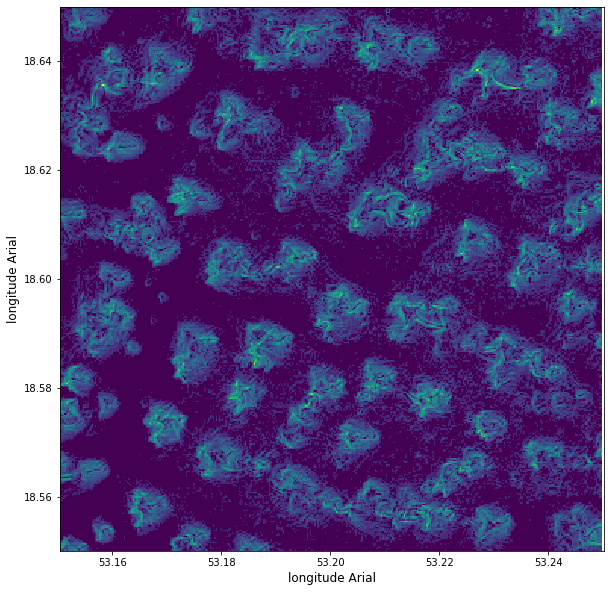

In [27]:
plt.pcolormesh(templon[1:],templat[1:],temp)
plt.axis('square')
plt.xlabel('longitude Arial', fontname="Arial", fontsize=12)
plt.ylabel('longitude Arial', fontsize=12)

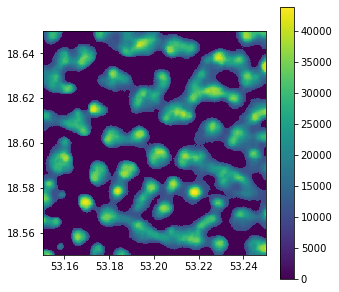

In [92]:
plt.pcolormesh(templon[1:],templat[1:],med)
plt.axis('square')
plt.colorbar()

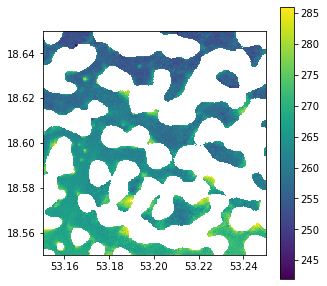

In [94]:
plt.pcolormesh(templon[1:],templat[1:],mask)
plt.axis('square')
plt.colorbar()

In [93]:
bedrockele = np.nanmedian(mask)
bedrockele

262.0

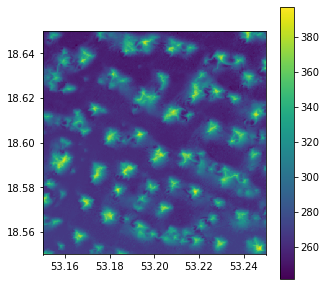

In [95]:
plt.pcolormesh(templon,templat,tempele)
plt.axis('square')
plt.colorbar()

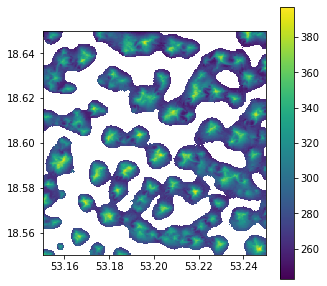

In [96]:
plt.pcolormesh(templon[1:],templat[1:],dunetopo)
plt.axis('square')
plt.colorbar()

In [97]:
meanheight = np.empty(len(templat[1:]))
for k in range(len(dunetopo)):
    tempslice = dunetopo[k]
    tempslicenonnansegments,templonnonnansegments = using_clump(tempslice,templon[1:])
    tempsum = 0
    for l in range(len(tempslicenonnansegments)):
        tempsum += np.mean(tempslicenonnansegments[l]-np.min(tempslicenonnansegments[l]))*len(tempslicenonnansegments[l])
    meanheight[k] = tempsum/len(tempslice)
equivalentthickness = np.mean(meanheight)

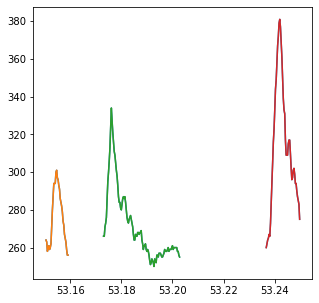

In [98]:
plt.plot(templon[1:],dunetopo[k])
for l in range(len(tempslicenonnansegments)):
    plt.plot(templonnonnansegments[l],tempslicenonnansegments[l])

In [99]:
len(dunetopo[~np.isnan(dunetopo)])/len(templon)/len(templat)

0.5607706592386259

In [100]:
equivalentthickness

16.84599523816934

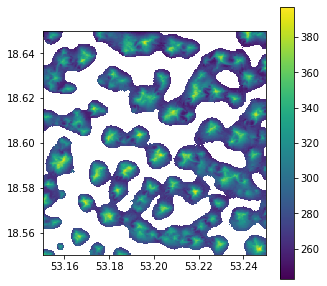

In [101]:
plt.pcolormesh(templon[1:],templat[1:],dunetopo)
plt.axis('square')
plt.colorbar()

In [102]:
templonflat,templatflat,tempdunetopoflat = np.ndarray.flatten(Templon[1:,1:]),np.ndarray.flatten(Templat[1:,1:]),np.ndarray.flatten(dunetopo)

In [103]:
thetabinwidth = 10
thetas = np.arange(-180+thetabinwidth/2,180,thetabinwidth)
thetas = thetas*np.pi/180

In [115]:
xspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
yspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
k = 4
tempx,tempy = DoRotation(xspan, yspan, RotRad=thetas[k])

l = 400

templontransect = tempx[l][(tempx[l]>=-dlon/2)&(tempx[l]<=dlon/2)&(tempy[l]>=-dlat/2)&(tempy[l]<=dlat/2)]+templonmid
templattransect = tempy[l][(tempx[l]>=-dlon/2)&(tempx[l]<=dlon/2)&(tempy[l]>=-dlat/2)&(tempy[l]<=dlat/2)]+templatmid
eletransect = griddata(np.vstack((templonflat,templatflat)).T,tempdunetopoflat,(templontransect,templattransect),method='nearest')

(53.090069033530575, 53.308550295858, 18.491449704142013, 18.709930966469432)

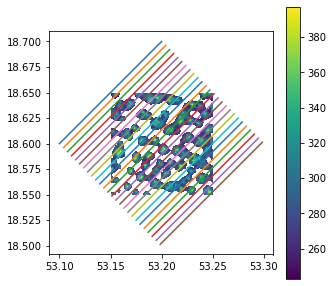

In [116]:
plt.pcolormesh(templon[1:],templat[1:],dunetopo)
plt.colorbar()
for i in range(0,len(tempx),20):
    plt.plot(tempx[i]+templonmid,tempy[i]+templatmid)
plt.axis('square')

(53.15041023325202, 53.250137682279764, 18.55017034434836, 18.649897793376105)

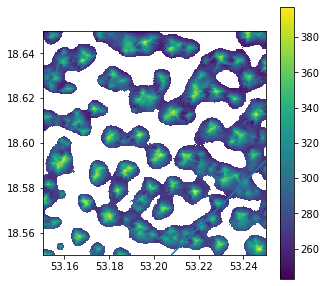

In [117]:
plt.pcolormesh(templon[1:],templat[1:],dunetopo)
plt.colorbar()
plt.plot(templontransect,templattransect)
plt.axis('square')

In [118]:
temps = np.linspace(0,np.diff(templon)[0]*len(templattransect),len(templattransect))
temptransectnonnansegments,tempsnonnansegments = using_clump(eletransect,temps)

fulllengthfraction = len(eletransect[~np.isnan(eletransect)])/len(eletransect)
bedformlengthsum = 0
facelengthsum = 0
heightsum = 0

for l in range(len(temptransectnonnansegments)):
    tempargmax = np.argmax(temptransectnonnansegments[l])
    facelengthsum += tempsnonnansegments[l][tempargmax]-tempsnonnansegments[l][0]
    heightsum += temptransectnonnansegments[l][tempargmax]-temptransectnonnansegments[l][0]
    bedformlengthsum += tempsnonnansegments[l][-1]-tempsnonnansegments[l][0]
lengthweightedslope = heightsum/facelengthsum
bedformlength = bedformlengthsum/len(temptransectnonnansegments)

(0.0, 0.1)

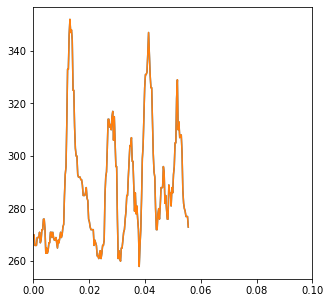

In [119]:
plt.plot(temps,eletransect)
for l in range(len(temptransectnonnansegments)):
    plt.plot(tempsnonnansegments[l],temptransectnonnansegments[l])
plt.xlim(0,dlon)

In [120]:
bedformlength

0.055540885774670055

In [110]:
thetabinwidth = 10
thetas = np.arange(-180+thetabinwidth/2,180,thetabinwidth)
thetas = thetas*np.pi/180
xspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
yspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
transectrange = np.arange(0,len(xspan),20)

templonflat,templatflat,tempdunetopoflat = np.ndarray.flatten(Templon[1:,1:]),np.ndarray.flatten(Templat[1:,1:]),np.ndarray.flatten(dunetopo)

lengthweightedslope = np.empty((len(thetas),len(transectrange)))
fulllengthfraction = np.empty((len(thetas),len(transectrange)))
bedformlength = np.empty((len(thetas),len(transectrange)))

for k in range(len(thetas)):
    
    tempx,tempy = DoRotation(xspan, yspan, RotRad=thetas[k])
    
    for l in range(len(transectrange)):
        templontransect = tempx[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templonmid    
        templattransect = tempy[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templatmid
        eletransect = griddata(np.vstack((templonflat,templatflat)).T,tempdunetopoflat,(templontransect,templattransect),method='nearest')

        if np.nansum(eletransect)>0:
            
            temps = np.linspace(0,np.diff(templon)[0]*len(templattransect),len(templattransect))
            temptransectnonnansegments,tempsnonnansegments = using_clump(eletransect,temps)

            fulllengthfraction[k,l] = len(eletransect[~np.isnan(eletransect)])/len(eletransect)
            facelengthsum = 0
            heightsum = 0
            bedformlengthsum = 0

            for m in range(len(temptransectnonnansegments)):
                tempargmax = np.argmax(temptransectnonnansegments[m])
                facelengthsum += tempsnonnansegments[m][tempargmax]-tempsnonnansegments[m][0]
                heightsum += temptransectnonnansegments[m][tempargmax]-temptransectnonnansegments[m][0]
                bedformlengthsum += tempsnonnansegments[m][-1]-tempsnonnansegments[m][0]

            bedformlength[k,l] = bedformlengthsum/len(temptransectnonnansegments)
                
            if facelengthsum>0:
                lengthweightedslope[k,l] = heightsum/facelengthsum
            else:
                lengthweightedslope[k,l] = np.nan
        else:
            fulllengthfraction[k,l] = np.nan
            lengthweightedslope[k,l] = np.nan
            bedformlength[k,l] = np.nan
            
fulllengthfractiontheta = np.nanmean(fulllengthfraction,axis=1)
lengthweightedslopetheta = np.nanmean(lengthweightedslope,axis=1)
bedformlengththeta = np.nanmean(bedformlength,axis=1)

(-180.0, 180.0)

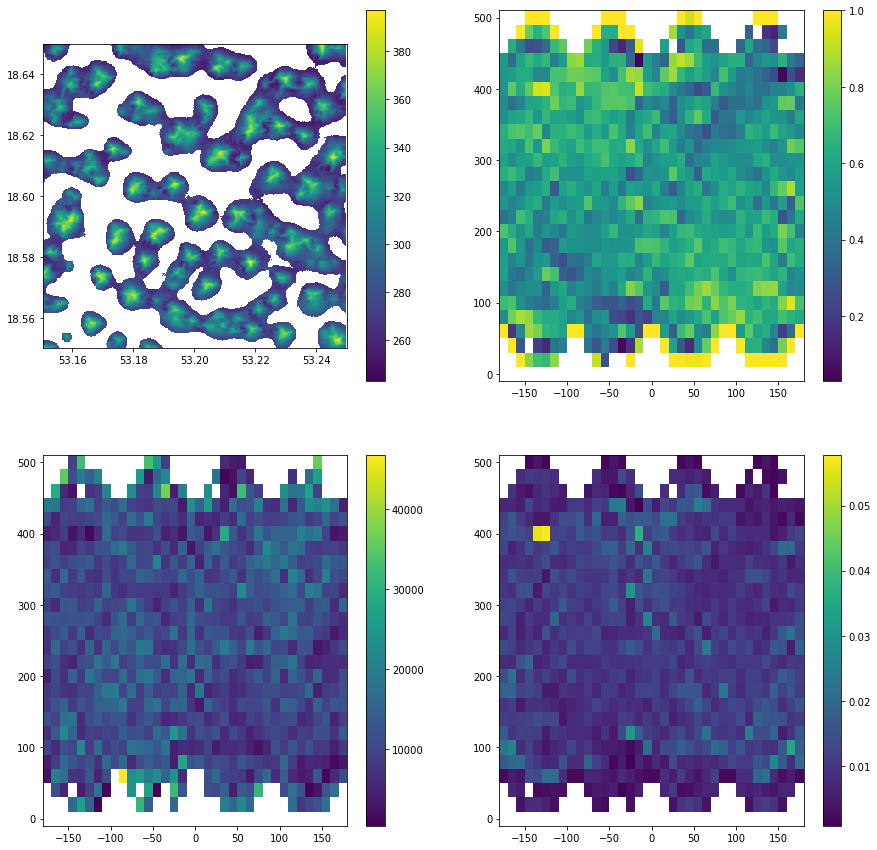

In [111]:
plt.rcParams['figure.figsize'] = [15, 15]

plt.subplot(221)
plt.pcolormesh(templon[1:],templat[1:],dunetopo)
plt.colorbar()
plt.plot(templontransect,templattransect)
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(thetas*180/np.pi,transectrange,fulllengthfraction.T)
plt.colorbar()
plt.xlim(-180,180)

plt.subplot(223)
plt.pcolormesh(thetas*180/np.pi,transectrange,lengthweightedslope.T)
plt.colorbar()
plt.xlim(-180,180)

plt.subplot(224)
plt.pcolormesh(thetas*180/np.pi,transectrange,bedformlength.T)
plt.colorbar()
plt.xlim(-180,180)

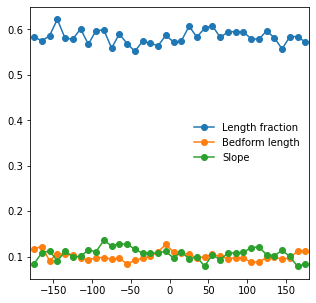

In [114]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(thetas*180/np.pi,fulllengthfractiontheta,'-o',label='Length fraction')
plt.plot(thetas*180/np.pi,bedformlengththeta*10,'-o',label='Bedform length')
plt.plot(thetas*180/np.pi,lengthweightedslopetheta*dlon/(Lx*Ly)**0.5,'-o',label='Slope')
plt.xlim(-180,180)
plt.legend(frameon=False)

(-180.0, 180.0)

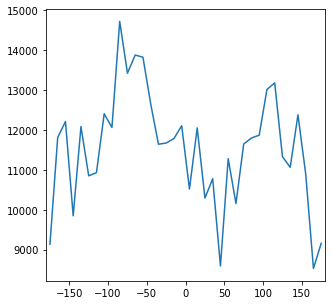

In [121]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(thetas*180/np.pi,lengthweightedslopetheta)
plt.xlim(-180,180)

# Generation

In [5]:
counter=0

for n in range(len(files)):
    
    templongrid = np.arange(lonbounds[n][0],lonbounds[n][1],dlon)
    templatgrid = np.arange(latbounds[n][0],latbounds[n][1],dlat)

    
    for i in range(len(templongrid)):
        for j in range(len(templatgrid)):    
            

            if dfpoly.contains(Point(templongrid[i],templatgrid[j])):
                counter+=1
print(counter)
timefortileseconds = 25
hourstocomplete = counter*timefortileseconds/60/60*1.1 #10% buffer
print(hourstocomplete)

1047
7.997916666666667


In [8]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
files = ['output_AW3D30-rubalkahliwest.tif','output_AW3D30-rubalkahlieast.tif']
lonbounds = [[49.0,53.2],[53.3,56.3]]
latbounds = [[18.0,23.2],[18.0,23.2]]

tempval = -1e-9 # dummyvar
absdetadlatlonthr = 1e+4
medfilterdiam=10

dlon = 0.1
dlat = 0.1

thetabinwidth = 10
thetas = np.arange(-180+thetabinwidth/2,180,thetabinwidth)
thetas = thetas*np.pi/180

for n in range(len(files)):
    img = gdal.Open(directory+files[n], gdal.GA_ReadOnly) 
    band = img.GetRasterBand(1)
    arr = np.flipud(band.ReadAsArray())

    width = img.RasterXSize
    height = img.RasterYSize
    gt = img.GetGeoTransform()
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3] 
    lon = np.linspace(minx,maxx,width)
    lat = np.linspace(miny,maxy,height)
    
    templongrid = np.arange(lonbounds[n][0],lonbounds[n][1],dlon)
    templatgrid = np.arange(latbounds[n][0],latbounds[n][1],dlat)

    bedrockele = np.empty((len(templatgrid),len(templongrid)))
    areafraction = np.empty((len(templatgrid),len(templongrid)))
    equivalentthickness = np.empty((len(templatgrid),len(templongrid)))
    fulllengthfractiontheta = np.empty((len(templatgrid),len(templongrid),len(thetas)))
    lengthweightedslopetheta = np.empty((len(templatgrid),len(templongrid),len(thetas)))
    bedformlengththeta = np.empty((len(templatgrid),len(templongrid),len(thetas)))
    
    start = time.time()
    counter=0
    
    for i in range(len(templongrid)):
        for j in range(len(templatgrid)):    

            if dfpoly.contains(Point(templongrid[i],templatgrid[j])):
                
                start = time.time()

                templonmid = templongrid[i]
                templatmid = templatgrid[j]

                templonmin = templonmid - dlon/2
                templonmax = templonmid + dlon/2
                templatmin = templatmid - dlat/2
                templatmax = templatmid + dlat/2

                loninds = np.ndarray.flatten(np.argwhere((lon>=templonmin)&(lon<=templonmax)))
                latinds = np.ndarray.flatten(np.argwhere((lat>=templatmin)&(lat<=templatmax)))

                templon = lon[loninds]
                templat = lat[latinds]
                tempele = arr[latinds][:,loninds]
                Templon,Templat = np.meshgrid(templon,templat)

                detadlat = np.diff(tempele,axis=0)/np.diff(templat)[:,np.newaxis]
                detadlon = np.diff(tempele,axis=1)/np.diff(templon)[np.newaxis,:]
                detadlatlon = (detadlat[:,1:]**2+detadlon[1:,:]**2)**0.5

                temp = np.copy(detadlatlon)
                temp[temp<absdetadlatlonthr] = tempval
                med = median(temp, disk(medfilterdiam))

                mask = np.copy(tempele[1:,1:]).astype(float)
                mask[med!=tempval] = np.nan
                mask[mask>np.nanmedian(mask)+np.std(tempele)] = np.nan

                dunetopo = np.copy(tempele[1:,1:]).astype(float)
                dunetopo[~np.isnan(mask)] = np.nan

                bedrockele[j,i] = np.nanmedian(mask)
                areafraction[j,i] = len(dunetopo[~np.isnan(dunetopo)])/(len(templon)-1)/(len(templat)-1)

                meanheight = np.empty(len(templat[1:]))
                for k in range(len(dunetopo)):
                    tempslice = dunetopo[k]
                    tempslicenonnansegments,templonnonnansegments = using_clump(tempslice,templon[1:])
                    tempsum = 0
                    for l in range(len(tempslicenonnansegments)):
                        tempsum += np.mean(tempslicenonnansegments[l]-np.min(tempslicenonnansegments[l]))*len(tempslicenonnansegments[l])
                    meanheight[k] = tempsum/len(tempslice)
                equivalentthickness[j,i] = np.mean(meanheight)
                
            ####
            
                xspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
                yspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
                transectrange = np.arange(0,len(xspan),30)

                templonflat,templatflat,tempdunetopoflat = np.ndarray.flatten(Templon[1:,1:]),np.ndarray.flatten(Templat[1:,1:]),np.ndarray.flatten(dunetopo)

                lengthweightedslope = np.empty((len(thetas),len(transectrange)))
                fulllengthfraction = np.empty((len(thetas),len(transectrange)))
                bedformlength = np.empty((len(thetas),len(transectrange)))

                for k in range(len(thetas)):

                    tempx,tempy = DoRotation(xspan, yspan, RotRad=thetas[k])

                    for l in range(len(transectrange)):
                        templontransect = tempx[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templonmid    
                        templattransect = tempy[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templatmid
                        eletransect = griddata(np.vstack((templonflat,templatflat)).T,tempdunetopoflat,(templontransect,templattransect),method='nearest')

                        if np.nansum(eletransect)>0:

                            temps = np.linspace(0,np.diff(templon)[0]*len(templattransect),len(templattransect))
                            temptransectnonnansegments,tempsnonnansegments = using_clump(eletransect,temps)

                            fulllengthfraction[k,l] = len(eletransect[~np.isnan(eletransect)])/len(eletransect)
                            
                            facelengthsum = 0
                            heightsum = 0
                            bedformlengthsum = 0

                            for m in range(len(temptransectnonnansegments)):
                                tempargmax = np.argmax(temptransectnonnansegments[m])
                                facelengthsum += tempsnonnansegments[m][tempargmax]-tempsnonnansegments[m][0]
                                heightsum += temptransectnonnansegments[m][tempargmax]-temptransectnonnansegments[m][0]
                                bedformlengthsum += tempsnonnansegments[m][-1]-tempsnonnansegments[m][0]

                            bedformlength[k,l] = bedformlengthsum/len(temptransectnonnansegments)
                            
                            if facelengthsum>0:
                                lengthweightedslope[k,l] = heightsum/facelengthsum
                            else:
                                lengthweightedslope[k,l] = np.nan
                        else:
                            fulllengthfraction[k,l] = np.nan
                            lengthweightedslope[k,l] = np.nan
                            bedformlength[k,l] = np.nan

                fulllengthfractiontheta[j,i]  = np.nanmean(fulllengthfraction,axis=1)
                lengthweightedslopetheta[j,i] = np.nanmean(lengthweightedslope,axis=1)
                bedformlengththeta[j,i] = np.nanmean(bedformlength,axis=1)
            
            else:
                areafraction[j,i] = np.nan
                equivalentthickness[j,i] = np.nan
                fulllengthfractiontheta[j,i] = np.nan
                lengthweightedslopetheta[j,i] = np.nan
                bedformlengththeta[j,i] = np.nan
                
            ####
            end = time.time()
            counter+=1
            print('%d of %d done on %d section, last real tile took %d seconds'%(counter,len(templongrid)*len(templatgrid),(n+1),(end-start)),end='\r')
            
    with open(directory+'%d_analyzed.pkl'%n, 'wb') as f:
        pickle.dump((templongrid,templatgrid,thetas,
                     areafraction,bedrockele,equivalentthickness,
                     fulllengthfractiontheta,lengthweightedslopetheta,bedformlengththeta), f)

In [ ]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
files = ['output_AW3D30-rubalkahliwest.tif','output_AW3D30-rubalkahlieast.tif']
lonbounds = [[49.0,53.2],[53.3,56.3]]
latbounds = [[18.0,23.2],[18.0,23.2]]

dlon = 0.1
dlat = 0.1

####

n = 0

img = gdal.Open(directory+files[n], gdal.GA_ReadOnly) 
band = img.GetRasterBand(1)
arr = np.flipud(band.ReadAsArray())

width = img.RasterXSize
height = img.RasterYSize
gt = img.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

templongrid0 = np.arange(lonbounds[n][0],lonbounds[n][1],dlon)
templatgrid0 = np.arange(latbounds[n][0],latbounds[n][1],dlat)

basemap0 = np.empty((len(templatgrid0),len(templongrid0)))

for i in range(len(templongrid0)):
    for j in range(len(templatgrid0)):    

        templonmid = templongrid0[i]
        templatmid = templatgrid0[j]

        templonmin = templonmid - dlon/2
        templonmax = templonmid + dlon/2
        templatmin = templatmid - dlat/2
        templatmax = templatmid + dlat/2

        loninds = np.ndarray.flatten(np.argwhere((lon>=templonmin)&(lon<=templonmax)))
        latinds = np.ndarray.flatten(np.argwhere((lat>=templatmin)&(lat<=templatmax)))

        tempele = arr[latinds][:,loninds]

        basemap0[j,i]  = np.mean(tempele)
        
####

n = 1

img = gdal.Open(directory+files[n], gdal.GA_ReadOnly) 
band = img.GetRasterBand(1)
arr = np.flipud(band.ReadAsArray())

width = img.RasterXSize
height = img.RasterYSize
gt = img.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

templongrid1 = np.arange(lonbounds[n][0],lonbounds[n][1],dlon)
templatgrid1 = np.arange(latbounds[n][0],latbounds[n][1],dlat)

basemap1 = np.empty((len(templatgrid1),len(templongrid1)))

for i in range(len(templongrid1)):
    for j in range(len(templatgrid1)):    

        templonmid = templongrid1[i]
        templatmid = templatgrid1[j]

        templonmin = templonmid - dlon/2
        templonmax = templonmid + dlon/2
        templatmin = templatmid - dlat/2
        templatmax = templatmid + dlat/2

        loninds = np.ndarray.flatten(np.argwhere((lon>=templonmin)&(lon<=templonmax)))
        latinds = np.ndarray.flatten(np.argwhere((lat>=templatmin)&(lat<=templatmax)))

        tempele = arr[latinds][:,loninds]
        
        basemap1[j,i]  = np.mean(tempele)
        
templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
basemap     = np.hstack((basemap0,basemap1))

with open(directory+'basemap.pkl', 'wb') as f:
    pickle.dump((templongrid,templatgrid,basemap), f)

# Analysis

In [11]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'

with open(directory+'basemap.pkl', 'rb') as f:
    (templongrid,templatgrid,basemap) = pickle.load(f)

n = 0
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid0,templatgrid0,thetas0,
    areafraction0,bedrockele0,equivalentthickness0,
    fulllengthfractiontheta0,lengthweightedslopetheta0,bedformlengththeta0) = pickle.load(f)
n = 1
with open(directory+'%d_analyzed.pkl'%n, 'rb') as f:
    (templongrid1,templatgrid1,thetas1,
    areafraction1,bedrockele1,equivalentthickness1,
    fulllengthfractiontheta1,lengthweightedslopetheta1,bedformlengththeta1) = pickle.load(f)
    
templongrid = np.hstack((templongrid0,templongrid1))
templatgrid = templatgrid0
thetas = thetas0
areafraction = np.hstack((areafraction0,areafraction1))
bedrockele = np.hstack((bedrockele0,bedrockele1))
equivalentthickness = np.hstack((equivalentthickness0,equivalentthickness1))
fulllengthfractiontheta = np.hstack((fulllengthfractiontheta0,fulllengthfractiontheta1))
lengthweightedslopetheta = np.hstack((lengthweightedslopetheta0,lengthweightedslopetheta1))
bedformlengththeta = np.hstack((bedformlengththeta0,bedformlengththeta1))

dlon = 0.1
dlat = 0.1

# convert the slope from eta/deg to eta/distance
r = 6371.229*1e+3
tlon = np.linspace(templongrid[0]-dlon/2,templongrid[-1]+dlon/2,len(templongrid)+1)
tlat = np.linspace(templatgrid[0]-dlat/2,templatgrid[-1]+dlat/2,len(templatgrid)+1)
Lon,Lat = np.meshgrid(tlon,tlat)
Ly = (r*np.diff(Lat*np.pi/180,axis=0))[:,1:]
Lx = (r*np.diff(Lon*np.pi/180,axis=1)*np.sin(np.pi/2-Lat[:,1:]*np.pi/180))[1:]
Ls = (Lx*Ly)**0.5
lengthweightedslopetheta = lengthweightedslopetheta*(dlon/Ls[:,:,np.newaxis])
fulllengththeta = fulllengthfractiontheta*Ls[:,:,np.newaxis]
bedrockele = bedrockele*equivalentthickness/equivalentthickness
bedformlengththeta = bedformlengththeta*(Ls[:,:,np.newaxis]/dlon)
beta = 1/np.nanmean(lengthweightedslopetheta)
mask = areafraction/areafraction

/local/k10/ag5517/tmp/ipykernel_514258/1870988452.py:40: RuntimeWarning: invalid value encountered in multiply
  bedrockele = bedrockele*equivalentthickness/equivalentthickness


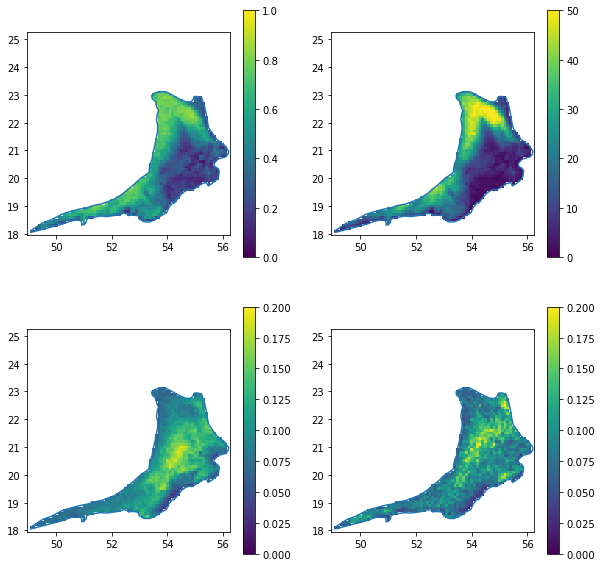

In [12]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,areafraction,vmin=0,vmax=1)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,equivalentthickness,vmin=0,vmax=50)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,np.mean(lengthweightedslopetheta,axis=2),vmin=0,vmax=0.2)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,np.max(lengthweightedslopetheta,axis=2)-np.min(lengthweightedslopetheta,axis=2),vmin=0,vmax=0.2)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

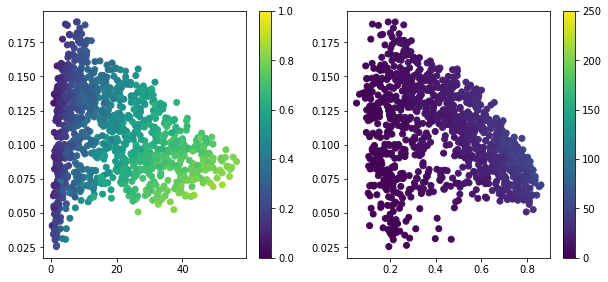

In [13]:
plt.subplot(221)
plt.scatter(np.ndarray.flatten(equivalentthickness),np.ndarray.flatten(np.mean(lengthweightedslopetheta,axis=2)),c=np.ndarray.flatten(areafraction),vmin=0,vmax=1)
plt.colorbar()
plt.subplot(222)
plt.scatter(np.ndarray.flatten(areafraction),np.ndarray.flatten(np.mean(lengthweightedslopetheta,axis=2)),c=np.ndarray.flatten(equivalentthickness),vmin=0,vmax=250)
plt.colorbar()

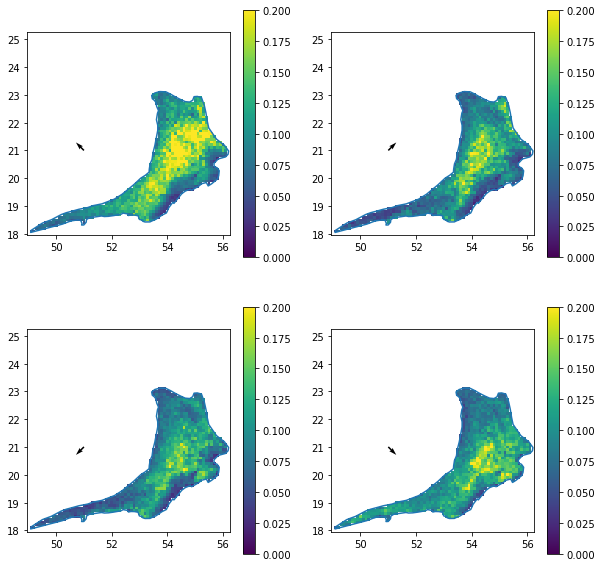

In [14]:
i = 31

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 22

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 4

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 13

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

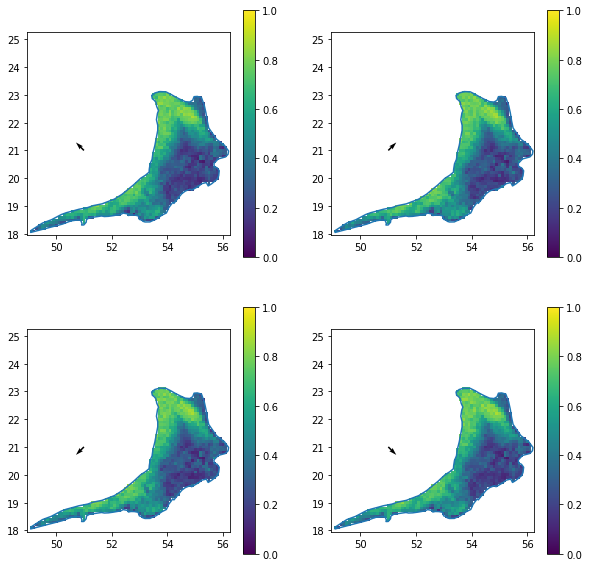

In [15]:
i = 31

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,fulllengthfractiontheta[:,:,i],vmin=0,vmax=1)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 22

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,fulllengthfractiontheta[:,:,i],vmin=0,vmax=1)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 4

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,fulllengthfractiontheta[:,:,i],vmin=0,vmax=1)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 13

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,fulllengthfractiontheta[:,:,i],vmin=0,vmax=1)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

18.80000000000001


(50.60000000000002, 53.900000000000006)

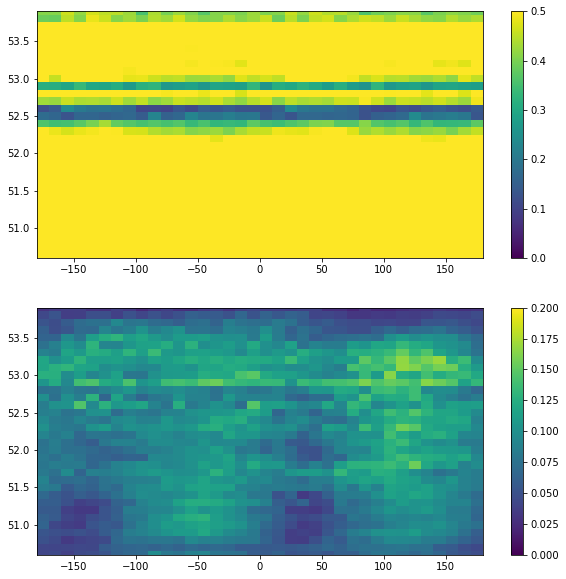

In [16]:
j = 8
print(templatgrid[j])

plt.subplot(211)
plt.pcolormesh(thetas*180/np.pi,templongrid,fulllengthfractiontheta[j],vmin=0,vmax=0.5)
plt.colorbar()
plt.ylim(np.min(templongrid[~np.isnan(fulllengthfractiontheta[j,:,0])]),np.max(templongrid[~np.isnan(fulllengthfractiontheta[j,:,0])]))

plt.subplot(212)
plt.pcolormesh(thetas*180/np.pi,templongrid,lengthweightedslopetheta[j],vmin=0,vmax=0.2)
plt.colorbar()
plt.ylim(np.min(templongrid[~np.isnan(lengthweightedslopetheta[j,:,0])]),np.max(templongrid[~np.isnan(lengthweightedslopetheta[j,:,0])]))

(48.95, 56.25000000000004, 17.95, 25.25000000000004)

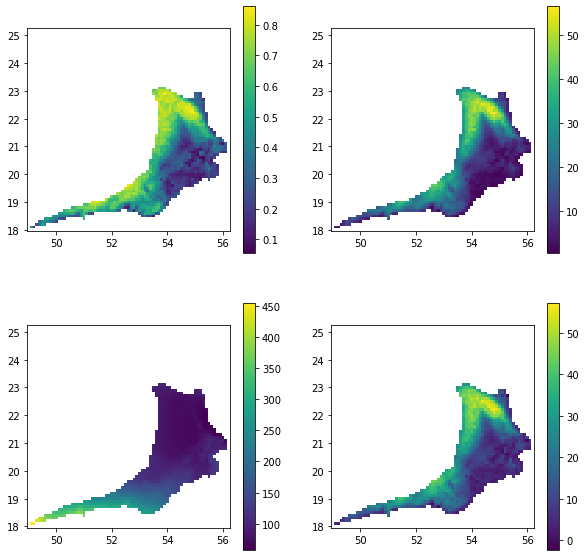

In [17]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,areafraction)
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,equivalentthickness)
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,bedrockele)
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,basemap-bedrockele)
plt.colorbar()
plt.axis('square')

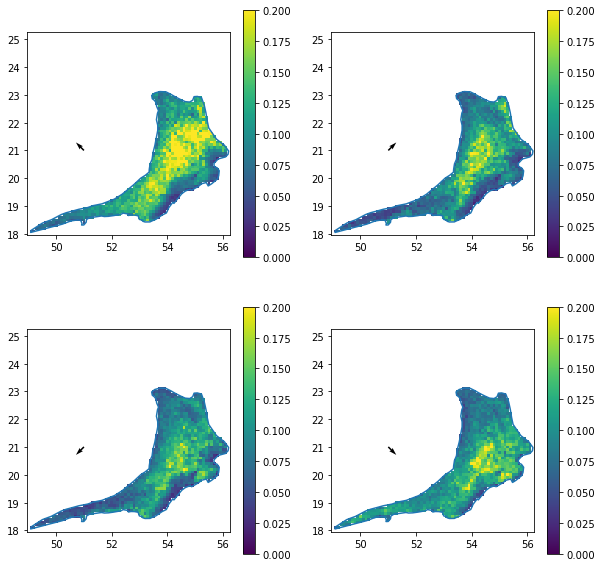

In [18]:
i = 31

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 22

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 4

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 13

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,lengthweightedslopetheta[:,:,i],vmin=0,vmax=0.2)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

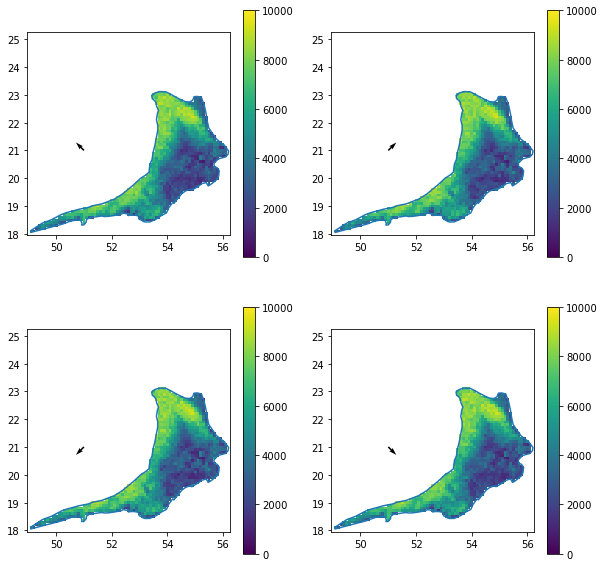

In [19]:
vmax = 1e+4

i = 31

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,fulllengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 22

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,fulllengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 4

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,fulllengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 13

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,fulllengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

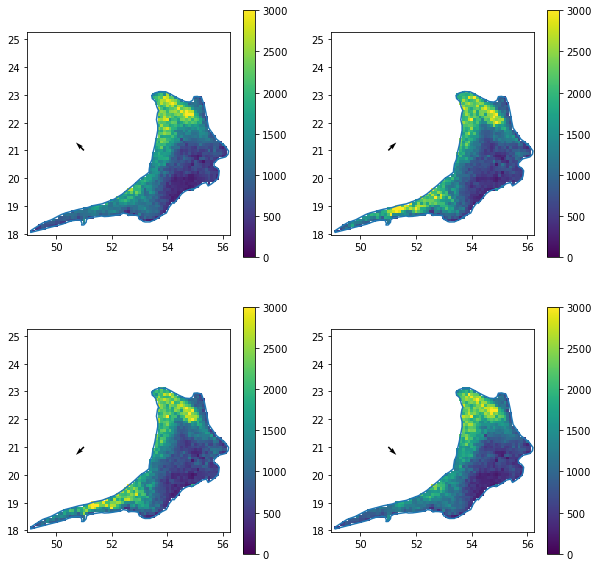

In [20]:
vmax = 3e+3

i = 31

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,bedformlengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 22

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,bedformlengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 4

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,bedformlengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

i = 13

plt.subplot(224)
plt.pcolormesh(templongrid,templatgrid,bedformlengththeta[:,:,i],vmin=0,vmax=vmax)
plt.colorbar()
plt.quiver(51,21,[np.cos(thetas[i])],[np.sin(thetas[i])])
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

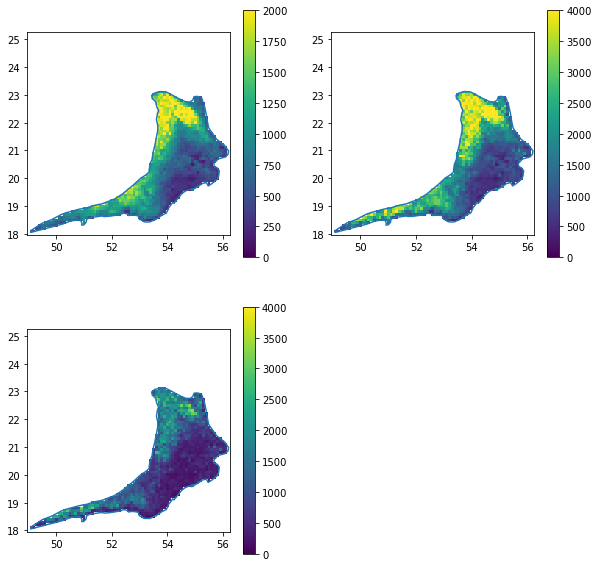

In [21]:
vmax = 2e+3

plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,np.min(bedformlengththeta,axis=2),vmin=0,vmax=vmax)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,np.max(bedformlengththeta,axis=2),vmin=0,vmax=vmax*2)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,np.max(bedformlengththeta,axis=2)-np.min(bedformlengththeta,axis=2),vmin=0,vmax=vmax*2)
plt.colorbar()
plt.axis('square')
plt.plot(*dfpoly.exterior.xy)

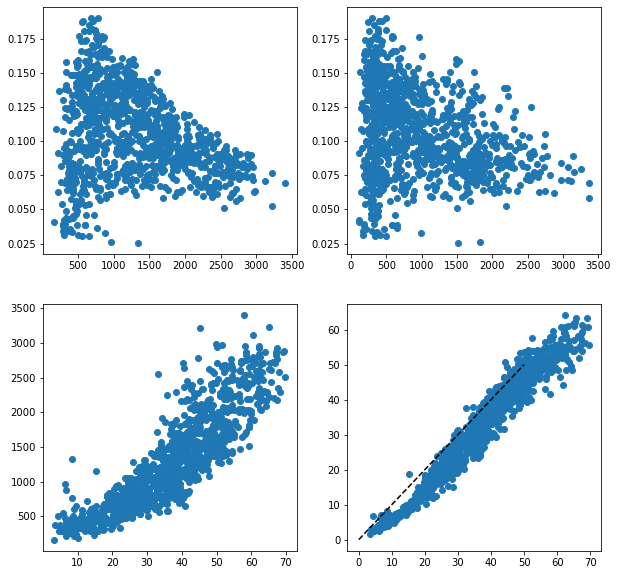

In [22]:
plt.subplot(221)
plt.scatter(np.mean(bedformlengththeta,axis=2),np.mean(lengthweightedslopetheta,axis=2))

plt.subplot(222)
plt.scatter(np.max(bedformlengththeta,axis=2)-np.min(bedformlengththeta,axis=2),np.mean(lengthweightedslopetheta,axis=2))

plt.subplot(223)
plt.scatter(equivalentthickness/areafraction,np.mean(bedformlengththeta,axis=2))

plt.subplot(224)
plt.scatter(equivalentthickness/areafraction,np.mean(lengthweightedslopetheta*bedformlengththeta,axis=2)/4)
plt.plot([0,50],[0,50],'--k')


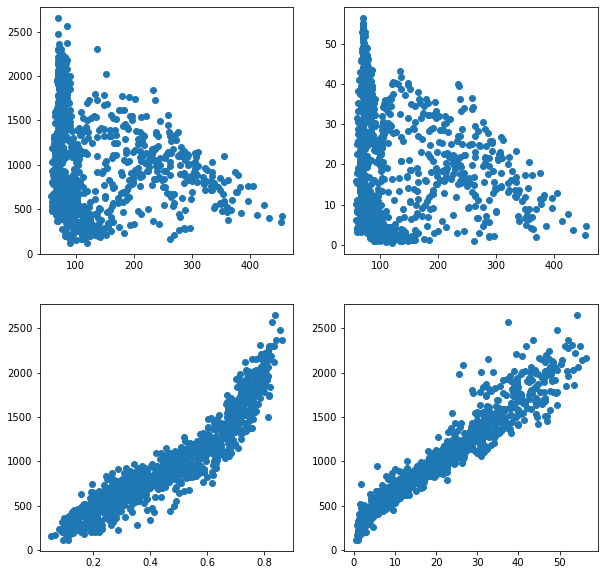

In [23]:
plt.subplot(221)
plt.scatter(bedrockele,np.min(bedformlengththeta,axis=2))

plt.subplot(222)
plt.scatter(bedrockele,equivalentthickness)

plt.subplot(223)
plt.scatter(areafraction,np.min(bedformlengththeta,axis=2))

plt.subplot(224)
plt.scatter(equivalentthickness,np.min(bedformlengththeta,axis=2))

(0.0, 1.0)

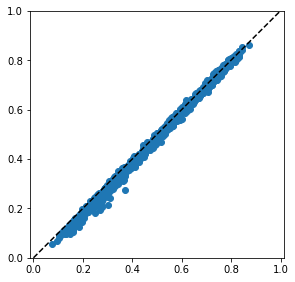

In [24]:
plt.subplot(221)
plt.scatter(np.mean(fulllengthfractiontheta,axis=2),areafraction)
plt.plot([0,1],[0,1],'--k')
plt.axis('equal')
plt.xlim(0,1)
plt.ylim(0,1)

In [25]:
thetasteepest = np.zeros_like(equivalentthickness)
thetashortest = np.zeros_like(equivalentthickness)

thetasteepestargs = np.argmax(lengthweightedslopetheta,axis=2)
thetashortestargs = np.argmin(bedformlengththeta,axis=2)
for i in range(len(templongrid)):
    for j in range(len(templatgrid)):
        thetasteepest[j,i] = thetas[thetasteepestargs[j,i]]
        thetashortest[j,i] = thetas[thetashortestargs[j,i]]

thetasteepest = thetasteepest*areafraction/areafraction
thetashortest = thetashortest*areafraction/areafraction

thetadiff_steepestshortest = thetasteepest-thetashortest
thetadiff_steepestshortest[thetadiff_steepestshortest> np.pi] = thetadiff_steepestshortest[thetadiff_steepestshortest> np.pi]-2*np.pi
thetadiff_steepestshortest[thetadiff_steepestshortest<-np.pi] = thetadiff_steepestshortest[thetadiff_steepestshortest<-np.pi]+2*np.pi

(-180.0, 180.0)

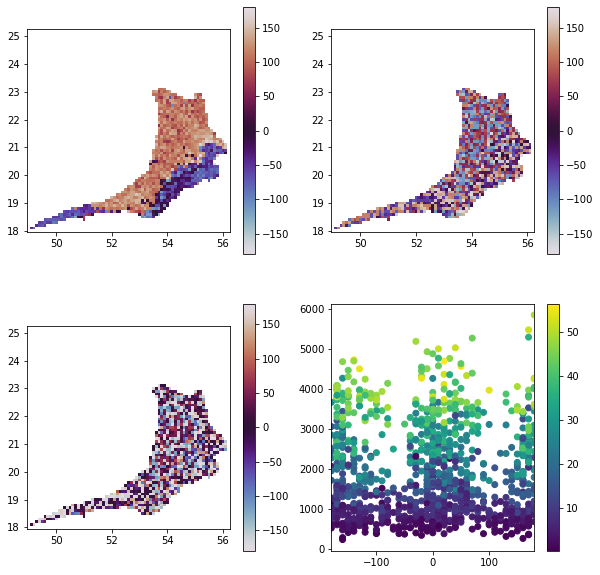

In [26]:
plt.subplot(221)
plt.pcolormesh(templongrid,templatgrid,thetasteepest*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(222)
plt.pcolormesh(templongrid,templatgrid,thetashortest*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(223)
plt.pcolormesh(templongrid,templatgrid,thetadiff_steepestshortest*180/np.pi,vmin=-180,vmax=180,cmap='twilight')
plt.colorbar()
plt.axis('square')

plt.subplot(224)
plt.scatter(thetadiff_steepestshortest*180/np.pi,np.max(bedformlengththeta,axis=2),c=equivalentthickness)
plt.colorbar()
plt.xlim(-180,180)

Text(0.5, 0, 'abs diff angle between steepest and shortest')

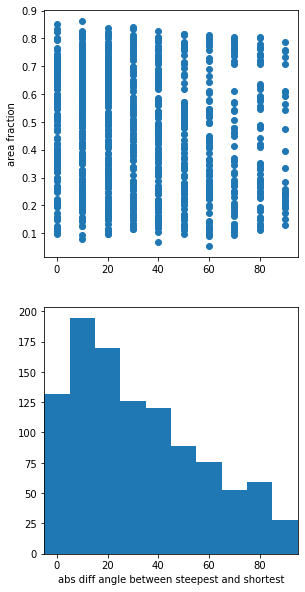

In [27]:
tempthetadiff_steepestshortest = np.pi/2-np.abs(np.abs(thetadiff_steepestshortest)-np.pi/2)

plt.subplot(221)
plt.scatter(tempthetadiff_steepestshortest*180/np.pi,areafraction)
plt.xlim(thetas[17]*180/np.pi,thetas[28-1]*180/np.pi)
plt.ylabel('area fraction')

tempthetadiff_steepestshortest = tempthetadiff_steepestshortest[~np.isnan(tempthetadiff_steepestshortest)]
plt.subplot(223)
plt.hist(tempthetadiff_steepestshortest*180/np.pi,bins=thetas[17:28]*180/np.pi)
plt.xlim(thetas[17]*180/np.pi,thetas[28-1]*180/np.pi)
plt.xlabel('abs diff angle between steepest and shortest')

# Figures

In [5]:
directory = '/g/data/k10/ag5517/rubalkhali-topo/'
files = ['output_AW3D30-rubalkahliwest.tif','output_AW3D30-rubalkahlieast.tif']
lonbounds = [[49.0,53.2],[53.3,56.3]]
latbounds = [[18.0,23.2],[18.0,23.2]]

n = 1

tempval = -1e-9 # dummyvar
absdetadlatlonthr = 1e+4
medfilterdiam=10

dlon = 0.1
dlat = 0.1

thetabinwidth = 10
thetas = np.arange(-180+thetabinwidth/2,180,thetabinwidth)
thetas = thetas*np.pi/180

img = gdal.Open(directory+files[n], gdal.GA_ReadOnly) 
band = img.GetRasterBand(1)
arr = np.flipud(band.ReadAsArray())

width = img.RasterXSize
height = img.RasterYSize
gt = img.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 
lon = np.linspace(minx,maxx,width)
lat = np.linspace(miny,maxy,height)

templongrid = np.arange(lonbounds[n][0],lonbounds[n][1],dlon)
templatgrid = np.arange(latbounds[n][0],latbounds[n][1],dlat)
    
bedrockele = np.empty((len(templatgrid),len(templongrid)))
areafraction = np.empty((len(templatgrid),len(templongrid)))
equivalentthickness = np.empty((len(templatgrid),len(templongrid)))
fulllengthfractiontheta = np.empty(len(thetas))
lengthweightedslopetheta = np.empty(len(thetas))
bedformlengththeta = np.empty(len(thetas))

templonmid = 54.5
templatmid = 21.3

templonmin = templonmid - dlon/2
templonmax = templonmid + dlon/2
templatmin = templatmid - dlat/2
templatmax = templatmid + dlat/2

loninds = np.ndarray.flatten(np.argwhere((lon>=templonmin)&(lon<=templonmax)))
latinds = np.ndarray.flatten(np.argwhere((lat>=templatmin)&(lat<=templatmax)))

templon = lon[loninds]
templat = lat[latinds]
tempele = arr[latinds][:,loninds]
Templon,Templat = np.meshgrid(templon,templat)

detadlat = np.diff(tempele,axis=0)/np.diff(templat)[:,np.newaxis]
detadlon = np.diff(tempele,axis=1)/np.diff(templon)[np.newaxis,:]
detadlatlon = (detadlat[:,1:]**2+detadlon[1:,:]**2)**0.5

temp = np.copy(detadlatlon)
temp[temp<absdetadlatlonthr] = tempval
med = median(temp, disk(medfilterdiam))

mask = np.copy(tempele[1:,1:]).astype(float)
mask[med!=tempval] = np.nan
mask[mask>np.nanmedian(mask)+np.std(tempele)] = np.nan

dunetopo = np.copy(tempele[1:,1:]).astype(float)
dunetopo[~np.isnan(mask)] = np.nan

bedrockele = np.nanmedian(mask)
areafraction = len(dunetopo[~np.isnan(dunetopo)])/(len(templon)-1)/(len(templat)-1)

meanheight = np.empty(len(templat[1:]))
for k in range(len(dunetopo)):
    tempslice = dunetopo[k]
    tempslicenonnansegments,templonnonnansegments = using_clump(tempslice,templon[1:])
    tempsum = 0
    for l in range(len(tempslicenonnansegments)):
        tempsum += np.mean(tempslicenonnansegments[l]-np.min(tempslicenonnansegments[l]))*len(tempslicenonnansegments[l])
    meanheight[k] = tempsum/len(tempslice)
equivalentthickness = np.mean(meanheight)

####

xspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
yspan = np.linspace(-dlon/2**0.5,dlon/2**0.5, int(len(templon)*2**0.5)+1)
transectrange = np.arange(0,len(xspan),30)

templonflat,templatflat,tempdunetopoflat = np.ndarray.flatten(Templon[1:,1:]),np.ndarray.flatten(Templat[1:,1:]),np.ndarray.flatten(dunetopo)

lengthweightedslope = np.empty((len(thetas),len(transectrange)))
fulllengthfraction = np.empty((len(thetas),len(transectrange)))
bedformlength = np.empty((len(thetas),len(transectrange)))

for k in range(len(thetas)):

    tempx,tempy = DoRotation(xspan, yspan, RotRad=thetas[k])

    for l in range(len(transectrange)):
        templontransect = tempx[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templonmid    
        templattransect = tempy[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templatmid
        eletransect = griddata(np.vstack((templonflat,templatflat)).T,tempdunetopoflat,(templontransect,templattransect),method='nearest')

        if np.nansum(eletransect)>0:

            temps = np.linspace(0,np.diff(templon)[0]*len(templattransect),len(templattransect))
            temptransectnonnansegments,tempsnonnansegments = using_clump(eletransect,temps)

            fulllengthfraction[k,l] = len(eletransect[~np.isnan(eletransect)])/len(eletransect)

            facelengthsum = 0
            heightsum = 0
            bedformlengthsum = 0

            for m in range(len(temptransectnonnansegments)):
                tempargmax = np.argmax(temptransectnonnansegments[m])
                facelengthsum += tempsnonnansegments[m][tempargmax]-tempsnonnansegments[m][0]
                heightsum += temptransectnonnansegments[m][tempargmax]-temptransectnonnansegments[m][0]
                bedformlengthsum += tempsnonnansegments[m][-1]-tempsnonnansegments[m][0]

            bedformlength[k,l] = bedformlengthsum/len(temptransectnonnansegments)

            if facelengthsum>0:
                lengthweightedslope[k,l] = heightsum/facelengthsum
            else:
                lengthweightedslope[k,l] = np.nan
        else:
            fulllengthfraction[k,l] = np.nan
            lengthweightedslope[k,l] = np.nan
            bedformlength[k,l] = np.nan

fulllengthfractiontheta  = np.nanmean(fulllengthfraction,axis=1)
lengthweightedslopetheta = np.nanmean(lengthweightedslope,axis=1)
bedformlengththeta = np.nanmean(bedformlength,axis=1)

In [6]:
viridis = cm.get_cmap('copper', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = to_rgba('grey')
newcolors[:int(256*absdetadlatlonthr/(np.max(detadlatlon)-np.min(detadlatlon))), :] = pink
newcmp = ListedColormap(newcolors)

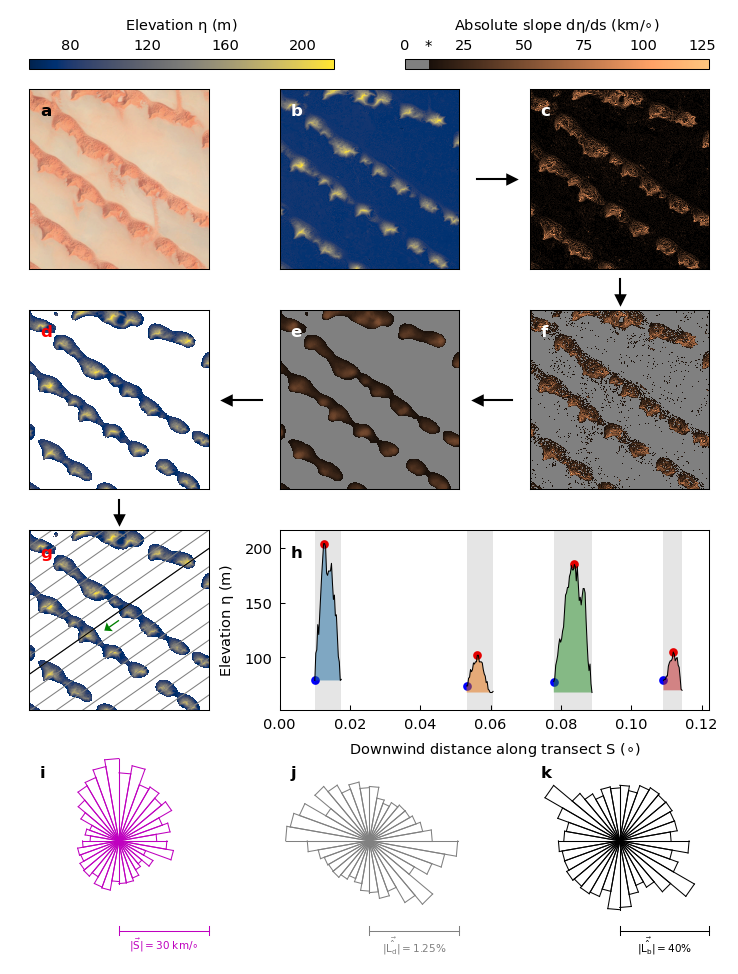

In [10]:
draft = False
polars = True

lw = 0.5
ss = 10

col1 = 'm'
col2 = 'grey'
col3 = 'k'
slopemaxlim = 30
bedformlengthmaxlim = 0.0125*1e+2
fulllengthmaxlim = 0.4*1e+2
tempadiff = np.diff(thetas)[0]/2

loi = 8
koi = 3
tempx,tempy = DoRotation(xspan, yspan, RotRad=thetas[koi])
templontransect = tempx[transectrange[loi]][(tempx[transectrange[loi]]>=-dlon/2)&(tempx[transectrange[loi]]<=dlon/2)&(tempy[transectrange[loi]]>=-dlat/2)&(tempy[transectrange[loi]]<=dlat/2)]+templonmid    
templattransect = tempy[transectrange[loi]][(tempx[transectrange[loi]]>=-dlon/2)&(tempx[transectrange[loi]]<=dlon/2)&(tempy[transectrange[loi]]>=-dlat/2)&(tempy[transectrange[loi]]<=dlat/2)]+templatmid
eletransect = griddata(np.vstack((templonflat,templatflat)).T,tempdunetopoflat,(templontransect,templattransect),method='nearest')
temps = np.linspace(0,np.diff(templon)[0]*len(templattransect),len(templattransect))
temptransectnonnansegments,tempsnonnansegments = using_clump(eletransect,temps)

figw = 120
figh = 160
cbh = 0.01
buffw = 0.1
buffh = buffw*figw/figh*0.58
pltspanh = 0.19
pltspanw = pltspanh/figw*figh
cbw = (pltspanw*3+buffw*2)/2-buffw/2
labbuf = 0.015

ax0l,ax0b,ax0w,ax0h = 0.02,0.03,pltspanw,pltspanh
ax1l,ax1b,ax1w,ax1h = ax0l+pltspanw+buffw,ax0b,pltspanw,pltspanh
ax2l,ax2b,ax2w,ax2h = ax0l+(pltspanw+buffw)*2,ax0b,pltspanw,pltspanh
ax3l,ax3b,ax3w,ax3h = ax0l,ax0b+pltspanh+buffh,pltspanw,pltspanh
ax4l,ax4b,ax4w,ax4h = ax0l+pltspanw+buffw,ax0b+pltspanh+buffh,pltspanw*2+buffw,pltspanh
ax5l,ax5b,ax5w,ax5h = ax0l,ax0b+(pltspanh+buffh)*2,pltspanw,pltspanh
ax6l,ax6b,ax6w,ax6h = ax0l+pltspanw+buffw,ax0b+(pltspanh+buffh)*2,pltspanw,pltspanh
ax7l,ax7b,ax7w,ax7h = ax0l+(pltspanw+buffw)*2,ax0b+(pltspanh+buffh)*2,pltspanw,pltspanh
ax8l,ax8b,ax8w,ax8h = ax0l,ax0b+(pltspanh+buffh)*3,pltspanw,pltspanh
ax9l,ax9b,ax9w,ax9h = ax0l+pltspanw+buffw,ax0b+(pltspanh+buffh)*3,pltspanw,pltspanh
ax10l,ax10b,ax10w,ax10h = ax0l+(pltspanw+buffw)*2,ax0b+(pltspanh+buffh)*3,pltspanw,pltspanh

cb0l,cb0b,cb0w,cb0h = ax0l,ax0b+(pltspanh+buffh)*4-buffh/2,cbw,cbh
cb1l,cb1b,cb1w,cb1h = ax0l+(pltspanw*3+buffw*2)/2+buffw/2,ax0b+(pltspanh+buffh)*4-buffh/2,cbw,cbh

fig = plt.gcf()

ax00 = fig.add_axes([0,0,1,1])
ax00.patch.set_alpha(0)
ax00.set_zorder(1)
if draft:
    plt.xticks([])
    plt.yticks([])
else:
    plt.axis('off')
    
ax00.text(ax8l+labbuf,ax8b+ax8h-labbuf,'a',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax9l+labbuf,ax9b+ax9h-labbuf,'b',fontsize=8, weight='bold',va='top',ha='left',color='white')
ax00.text(ax10l+labbuf,ax10b+ax10h-labbuf,'c',fontsize=8, weight='bold',va='top',ha='left',color='white')
ax00.text(ax5l+labbuf,ax5b+ax5h-labbuf,'d',fontsize=8, weight='bold',va='top',ha='left',color='red')
ax00.text(ax6l+labbuf,ax6b+ax6h-labbuf,'e',fontsize=8, weight='bold',va='top',ha='left',color='white')
ax00.text(ax7l+labbuf,ax7b+ax7h-labbuf,'f',fontsize=8, weight='bold',va='top',ha='left',color='white')
ax00.text(ax3l+labbuf,ax3b+ax3h-labbuf,'g',fontsize=8, weight='bold',va='top',ha='left',color='red')
ax00.text(ax4l+labbuf,ax4b+ax4h-labbuf,'h',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax0l+labbuf,ax0b+ax0h-labbuf,'i',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax1l+labbuf,ax1b+ax1h-labbuf,'j',fontsize=8, weight='bold',va='top',ha='left')
ax00.text(ax2l+labbuf,ax2b+ax2h-labbuf,'k',fontsize=8, weight='bold',va='top',ha='left')

ax00.plot([ax0l+pltspanw/2,ax0l+pltspanw/2+ax0w/2],[ax0b,ax0b],lw=lw,c=col1)
ax00.plot([ax0l+pltspanw/2,ax0l+pltspanw/2],[ax0b+cbh/2,ax0b-cbh/2],lw=lw,c=col1)
ax00.plot([ax0l+pltspanw/2+ax0w/2,ax0l+pltspanw/2+ax0w/2],[ax0b+cbh/2,ax0b-cbh/2],lw=lw,c=col1)
ax00.text(ax0l+pltspanw/2+ax0w/4,ax0b-cbh*1.5,'$|\\vec{S}|=%d$ km/$\\circ$'%slopemaxlim,color=col1,ha='center',va='center',fontsize=5)
ax00.plot([ax1l+pltspanw/2,ax1l+pltspanw/2+ax1w/2],[ax1b,ax1b],lw=lw,c=col2)
ax00.plot([ax1l+pltspanw/2,ax1l+pltspanw/2],[ax1b+cbh/2,ax1b-cbh/2],lw=lw,c=col2)
ax00.plot([ax1l+pltspanw/2+ax1w/2,ax1l+pltspanw/2+ax1w/2],[ax1b+cbh/2,ax1b-cbh/2],lw=lw,c=col2)
ax00.text(ax1l+pltspanw/2+ax1w/4,ax1b-cbh*1.5,'$|\\vec{\\hat{L_d}}|=%.2f$%%'%bedformlengthmaxlim,color=col2,ha='center',va='center',fontsize=5)
ax00.plot([ax2l+pltspanw/2,ax2l+pltspanw/2+ax2w/2],[ax2b,ax2b],lw=lw,c=col3)
ax00.plot([ax2l+pltspanw/2,ax2l+pltspanw/2],[ax2b+cbh/2,ax2b-cbh/2],lw=lw,c=col3)
ax00.plot([ax2l+pltspanw/2+ax2w/2,ax2l+pltspanw/2+ax2w/2],[ax2b+cbh/2,ax2b-cbh/2],lw=lw,c=col3)
ax00.text(ax2l+pltspanw/2+ax2w/4,ax2b-cbh*1.5,'$|\\vec{\\hat{L_b}}|=%d$%%'%fulllengthmaxlim,color=col3,ha='center',va='center',fontsize=5)
plt.plot([ax10l-buffw*3/4,ax10l-buffw/4],[ax10b+pltspanh/2,ax10b+pltspanh/2],'k',lw=lw*2)
plt.scatter(ax10l-buffw/4,ax10b+pltspanh/2,marker='>',c='k',lw=0)
plt.plot([ax10l+pltspanw/2,ax10l+pltspanw/2],[ax10b-buffh/4,ax10b-buffh*3/4],'k',lw=lw*2)
plt.scatter(ax10l+pltspanw/2,ax10b-buffh*3/4,marker='v',c='k',lw=0)
plt.plot([ax7l-buffw*3/4,ax7l-buffw/4],[ax7b+pltspanh/2,ax7b+pltspanh/2],'k',lw=lw*2)
plt.scatter(ax7l-buffw*3/4,ax7b+pltspanh/2,marker='<',c='k',lw=0)
plt.plot([ax6l-buffw*3/4,ax6l-buffw/4],[ax6b+pltspanh/2,ax6b+pltspanh/2],'k',lw=lw*2)
plt.scatter(ax6l-buffw*3/4,ax6b+pltspanh/2,marker='<',c='k',lw=0)
plt.plot([ax5l+pltspanw/2,ax5l+pltspanw/2],[ax5b-buffh/4,ax5b-buffh*3/4],'k',lw=lw*2)
plt.scatter(ax5l+pltspanw/2,ax5b-buffh*3/4,marker='v',c='k',lw=0)
ax00.set_xlim(0,1)
ax00.set_ylim(0,1)

if polars:
    ax0 = fig.add_axes([ax0l,ax0b,ax0w,ax0h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[lengthweightedslopetheta[k]*1e-3,lengthweightedslopetheta[k]*1e-3],lw=lw,c=col1)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,lengthweightedslopetheta[k]*1e-3],lw=lw,c=col1)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,lengthweightedslopetheta[k]*1e-3],lw=lw,c=col1)
    plt.ylim(0,slopemaxlim)
    
    ax1 = fig.add_axes([ax1l,ax1b,ax1w,ax1h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[bedformlengththeta[k]*1e+2,bedformlengththeta[k]*1e+2],lw=lw,c=col2)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,bedformlengththeta[k]*1e+2],lw=lw,c=col2)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,bedformlengththeta[k]*1e+2],lw=lw,c=col2) 
    plt.ylim(0,bedformlengthmaxlim)
    
    ax2 = fig.add_axes([ax2l,ax2b,ax2w,ax2h],projection='polar')
    for k in range(len(thetas)):
        plt.plot([thetas[k]-tempadiff,thetas[k]+tempadiff],[fulllengthfractiontheta[k]*1e+2,fulllengthfractiontheta[k]*1e+2],lw=lw,c=col3)
        plt.plot([thetas[k]-tempadiff,thetas[k]-tempadiff],[0,fulllengthfractiontheta[k]*1e+2],lw=lw,c=col3)
        plt.plot([thetas[k]+tempadiff,thetas[k]+tempadiff],[0,fulllengthfractiontheta[k]*1e+2],lw=lw,c=col3)  
    plt.ylim(0,fulllengthmaxlim)
    
ax3 = fig.add_axes([ax3l,ax3b,ax3w,ax3h])
plt.pcolormesh(templon,templat,dunetopo,cmap='cividis',rasterized=True)
for l in range(len(transectrange)):
    plt.plot(tempx[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templonmid,
             tempy[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templatmid,c='grey',lw=lw)
    if l==loi:
        plt.plot(tempx[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templonmid,
                 tempy[transectrange[l]][(tempx[transectrange[l]]>=-dlon/2)&(tempx[transectrange[l]]<=dlon/2)&(tempy[transectrange[l]]>=-dlat/2)&(tempy[transectrange[l]]<=dlat/2)]+templatmid,c='k',lw=lw)
plt.quiver(templonmid,templatmid,np.cos(thetas[koi]),np.sin(thetas[koi]),scale=10,color='g',headwidth=8)
plt.xticks([])
plt.yticks([])

ax4 = fig.add_axes([ax4l,ax4b,ax4w,ax4h])
for m in range(len(temptransectnonnansegments)):
    plt.scatter(tempsnonnansegments[m][np.argmax(temptransectnonnansegments[m])],temptransectnonnansegments[m][np.argmax(temptransectnonnansegments[m])],s=ss,c='r')
    plt.scatter(tempsnonnansegments[m][0],temptransectnonnansegments[m][0],s=ss,c='b')
    plt.fill_between(tempsnonnansegments[m],np.min(temptransectnonnansegments[m]),temptransectnonnansegments[m],alpha=0.5,lw=0)
    plt.fill_betweenx([np.min(tempele),np.max(tempele)],tempsnonnansegments[m][0],tempsnonnansegments[m][-1],alpha=0.1,color='k',lw=0)
plt.plot(temps,eletransect,c='k',lw=lw)
plt.xlim(temps[0],temps[-1])
plt.ylim(np.min(tempele),np.max(tempele))
ax4.set_xlabel('Downwind distance along transect $S$ ($\\circ$)')
ax4.set_ylabel('Elevation $\\eta$ (m)')

ax5 = fig.add_axes([ax5l,ax5b,ax5w,ax5h])
p5 = plt.pcolormesh(templon,templat,dunetopo,cmap='cividis',rasterized=True)
plt.xticks([])
plt.yticks([])

ax6 = fig.add_axes([ax6l,ax6b,ax6w,ax6h])
p6 = plt.pcolormesh(templon,templat,med*1e-3,vmin=np.min(detadlatlon)*1e-3,vmax=np.max(detadlatlon)*1e-3,cmap=newcmp,rasterized=True)
plt.xticks([])
plt.yticks([])

ax7 = fig.add_axes([ax7l,ax7b,ax7w,ax7h])
plt.pcolormesh(templon,templat,temp*1e-3,vmin=np.min(detadlatlon)*1e-3,vmax=np.max(detadlatlon)*1e-3,cmap=newcmp,rasterized=True)
plt.xticks([])
plt.yticks([])

ax8 = fig.add_axes([ax8l,ax8b,ax8w,ax8h])
img = mpimg.imread(directory+'figures/im231545_gridtile.png')
plt.imshow(img)
plt.xticks([])
plt.yticks([])

ax9 = fig.add_axes([ax9l,ax9b,ax9w,ax9h])
plt.pcolormesh(templon,templat,tempele,cmap='cividis',rasterized=True)
plt.xticks([])
plt.yticks([])

ax10 = fig.add_axes([ax10l,ax10b,ax10w,ax10h])
plt.pcolormesh(templon,templat,detadlatlon*1e-3,vmin=np.min(detadlatlon)*1e-3,vmax=np.max(detadlatlon)*1e-3,cmap='copper',rasterized=True)
plt.xticks([])
plt.yticks([])

cbar0_ax = fig.add_axes([cb0l,cb0b,cb0w,cb0h])
cb0 = fig.colorbar(p5, orientation='horizontal',cax=cbar0_ax, ticks=[80,120,160,200])
cbar0_ax.xaxis.set_label_position('top')
cbar0_ax.xaxis.set_ticks_position('top')
cb0.ax.set_xlabel('Elevation $\\eta$ (m)')
cb0.ax.set_xticklabels([80,120,160,200])

cbar1_ax = fig.add_axes([cb1l,cb1b,cb1w,cb1h])
cb1 = fig.colorbar(p6, orientation='horizontal',cax=cbar1_ax, ticks=[0,absdetadlatlonthr*1e-3,25,50,75,100,125])
cbar1_ax.xaxis.set_label_position('top')
cbar1_ax.xaxis.set_ticks_position('top')
cb1.ax.set_xlabel('Absolute slope $d\\eta/ds$ (km/$\\circ$)')
cb1.ax.set_xticklabels([0,'*',25,50,75,100,125])

for ax in fig.axes:
    ax.tick_params(width=lw,length=lw*5,which='both',direction='in')
    ax.minorticks_off()
    if str(type(ax))=="<class 'matplotlib.projections.polar.PolarAxes'>":
        ax.axis('off')
    else:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
cb0.ax.tick_params(width=0,length=0,which='both',direction='in')
cb0.outline.set_linewidth(lw)
cb1.ax.tick_params(width=0,length=0,which='both',direction='in')
cb1.outline.set_linewidth(lw)

fig.set_size_inches(figw/25.4,figh/25.4,forward=True)
if draft==False:
    plt.savefig(directory+'figures/figS1.pdf',dpi=300)
    plt.savefig(directory+'figures/figS1.png',dpi=300)